In [228]:
import numpy as np

import pandas as pd
from pandas import DataFrame as DF

import statsmodels.api as sm


import matplotlib.pyplot as plt
import seaborn as sns

def histograms(df, columns, per_row=3, bins=5, width=5, height=4):
    n = len(columns)
    rows = math.ceil(n / per_row)

    fig, axes = plt.subplots(rows, per_row, figsize=(width * per_row, height * rows))
    axes = axes.flatten()

    for ax, col in zip(axes, columns):
        sns.histplot(data=df, x=col, ax=ax, bins=bins)
        ax.set_title(col)
        ax.set_xlabel("")  # cleaner
        ax.set_ylabel("count")
        ax.tick_params(axis='x', rotation=45)

    # Turn off unused axes
    for ax in axes[n:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Questão 3

> Esta questão aborda a aplicação prática de um problema de ANOVA (Análise de Variância) utilizando dados reais empregados em contextos empresariais. O objetivo é analisar as médias de quantidades e preços de produtos agrupados por paı́ses, utilizando o conjunto de dados Vendas de Varejo Online. Siga os passos abaixo para desenvolver sua solução.


## Análise Descritiva dos Dados

In [65]:
import pandas as pd

q3_df = pd.read_excel("online_retail_II.xlsx")

In [66]:
q3_df.head(3)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom


In [122]:
len(q3_df)

525461

In [67]:
q3_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


Sete colunas.
### Preparação de dados
Há alguns valores nulos em Description e Customer ID, mas essas colunas não devem afetar nossas operações, então não vou remover tais linhas.

Nosso interesse: produtos, países e preço. Removamos todas as outras. Mantendo description para interpretação, e Invoice para remover cancelamentos.

In [70]:
relevant_cols_df = q3_df.drop(['InvoiceDate', 'Customer ID'], axis=1)

Segundo a documentação da base, transações que começam com `c` indicam cancelamento. Vejamos quantas há:

In [174]:
relevant_cols_df["Invoice"].str.startswith(('C', 'c'), na=False).sum()

np.int64(10206)

In [175]:
no_cancel_df = relevant_cols_df[~relevant_cols_df["Invoice"].str.startswith(('C', 'c'), na=False)]

Removidos os cancelmanentos, observemos as estatísticas:

In [182]:
no_cancel_df.describe()

,Quantity,Price
count,515255.000000,515255.000000
mean,10.956631,3.956373
std,104.354013,127.688563
min,-9600.000000,-53594.360000
25%,1.000000,1.250000
50%,3.000000,2.100000
75%,10.000000,4.210000
max,19152.000000,25111.090000


Ainda há valores negativos. Vamos removê-los.

In [187]:
no_neg_df = no_cancel_df[(no_cancel_df['Quantity'] > 0) & (no_cancel_df['Price'] > 0)]

In [188]:
print(f'Número de países: {no_neg_df['Country'].unique().size}')
print(f'Número de produtos: {no_neg_df['Description'].unique().size}')

Número de países: 40
Número de produtos: 4534


In [183]:
products_per_country_df = DF(
    no_neg_df.groupby('Country')['StockCode'].unique().apply(len)
).rename({'StockCode': 'SKUs'}, axis=1)
products_per_country_df

,SKUs
Country,
Australia,418
Austria,363
Bahrain,93
Belgium,481
Bermuda,34
Brazil,61
Canada,77
Channel Islands,541
Cyprus,417


In [189]:
no_neg_df.describe()

,Quantity,Price
count,511565.00000,511565.000000
mean,11.40017,4.251841
std,86.76126,63.662597
min,1.00000,0.001000
25%,1.00000,1.250000
50%,3.00000,2.100000
75%,10.00000,4.210000
max,19152.00000,25111.090000


"Unspecified" não nos interessa, removendo-os':

In [190]:
specified_countries_df = no_neg_df[no_neg_df['Country'] != 'Unspecified']
specified_countries_df.describe()

,Quantity,Price
count,511259.000000,511259.000000
mean,11.400277,4.252465
std,86.786769,63.681599
min,1.000000,0.001000
25%,1.000000,1.250000
50%,3.000000,2.100000
75%,10.000000,4.210000
max,19152.000000,25111.090000


### Gráficos de distribuiçoes

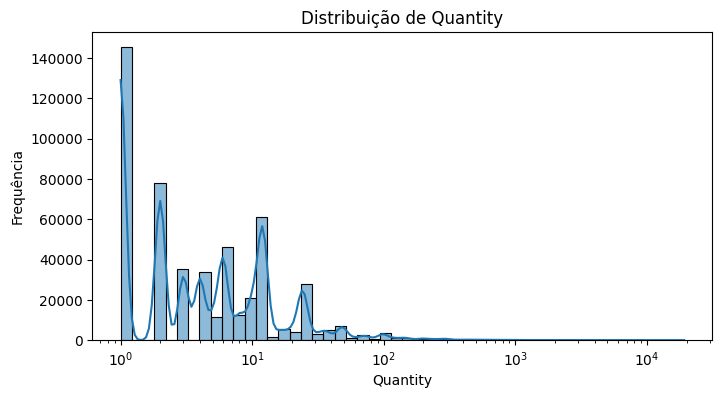

In [129]:
plt.figure(figsize=(8, 4))
sns.histplot(specified_countries_df['Quantity'], bins=50, kde=True, log_scale=True)
plt.title('Distribuição de Quantity')
plt.xlabel('Quantity')
plt.ylabel('Frequência')
plt.show()

Grande variedade de quantidades, a maioria em valores pequenos entre 1 e 100.

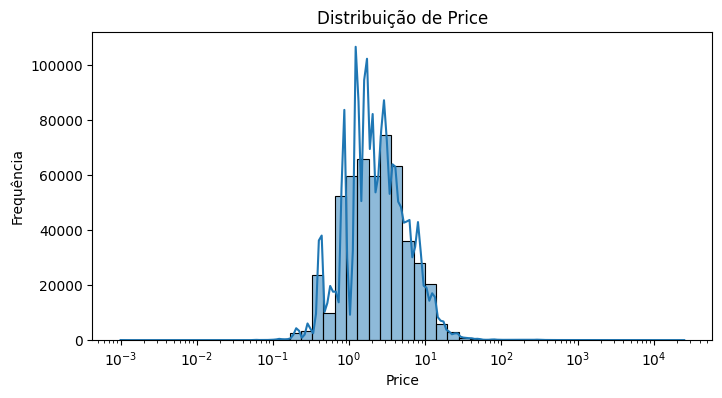

In [130]:
plt.figure(figsize=(8, 4))
sns.histplot(specified_countries_df['Price'], bins=50, kde=True, log_scale=True)
plt.title('Distribuição de Price')
plt.xlabel('Price')
plt.ylabel('Frequência')
plt.show()

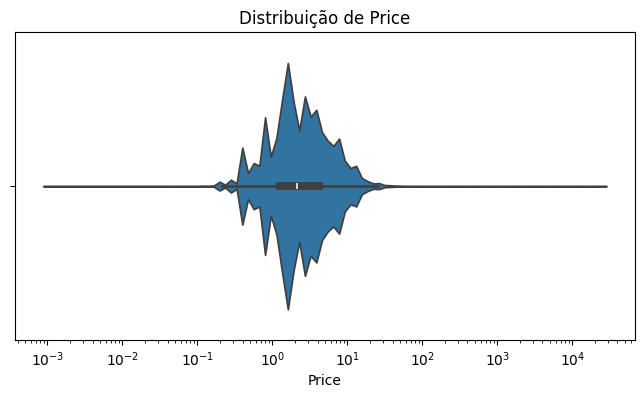

In [137]:
plt.figure(figsize=(8, 4))
sns.violinplot(x=specified_countries_df['Price'], log_scale=True)
plt.title('Distribuição de Price')
plt.xlabel('Price')
plt.show()

Preços parecem seguir uma distribuição nornmal.

### Mèdias por país e produto

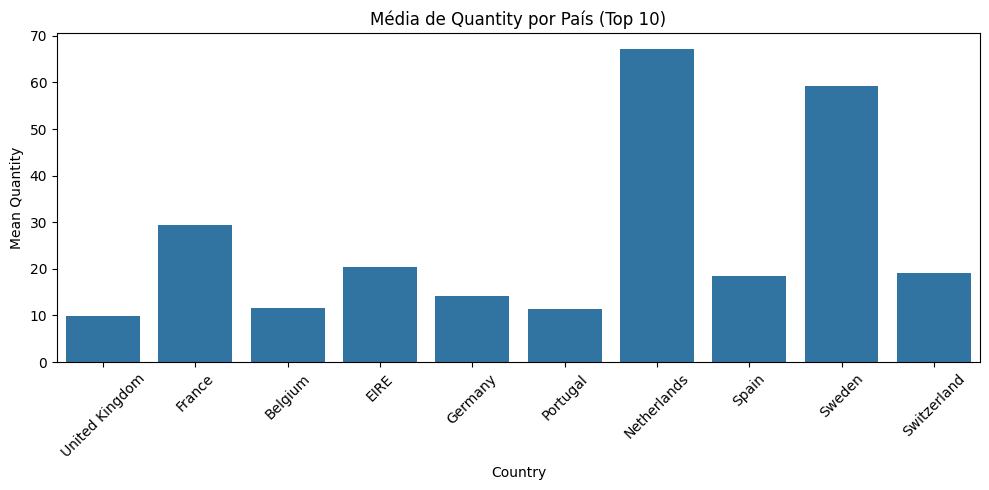

In [140]:
top_countries = specified_countries_df['Country'].value_counts().head(10).index
df_top = specified_countries_df[specified_countries_df['Country'].isin(top_countries)]

plt.figure(figsize=(10, 5))
sns.barplot(
    data=df_top,
    x='Country',
    y='Quantity',
    estimator='mean',
    errorbar=None
)
plt.title('Média de Quantity por País (Top 10)')
plt.xticks(rotation=45)
plt.xlabel('Country')
plt.ylabel('Mean Quantity')
plt.tight_layout()
plt.show()


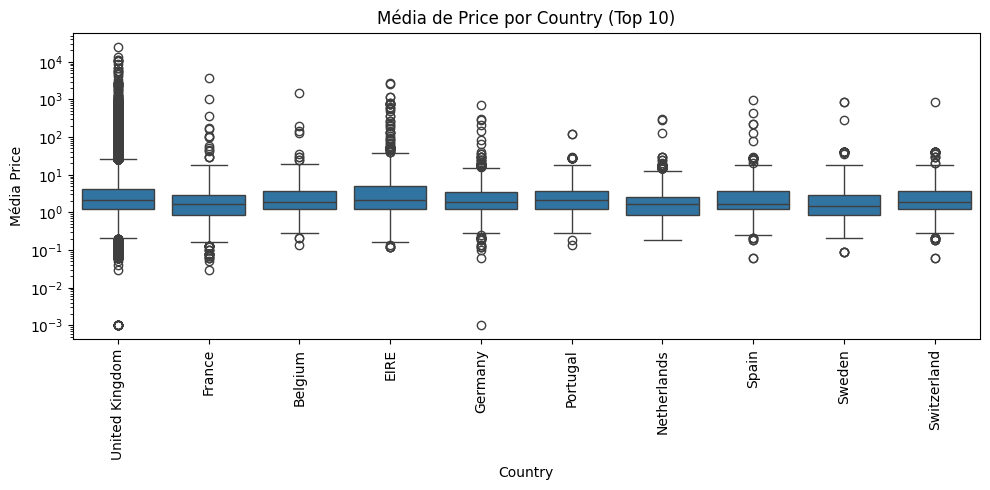

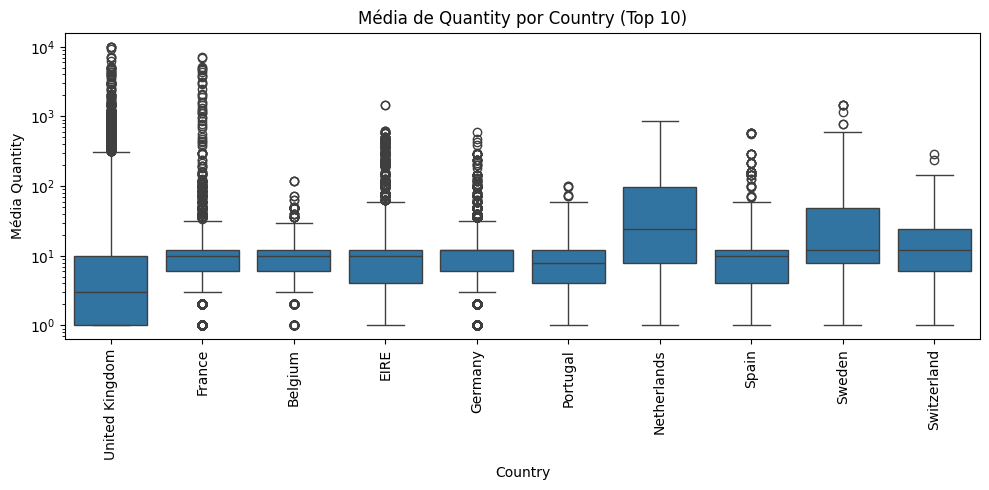

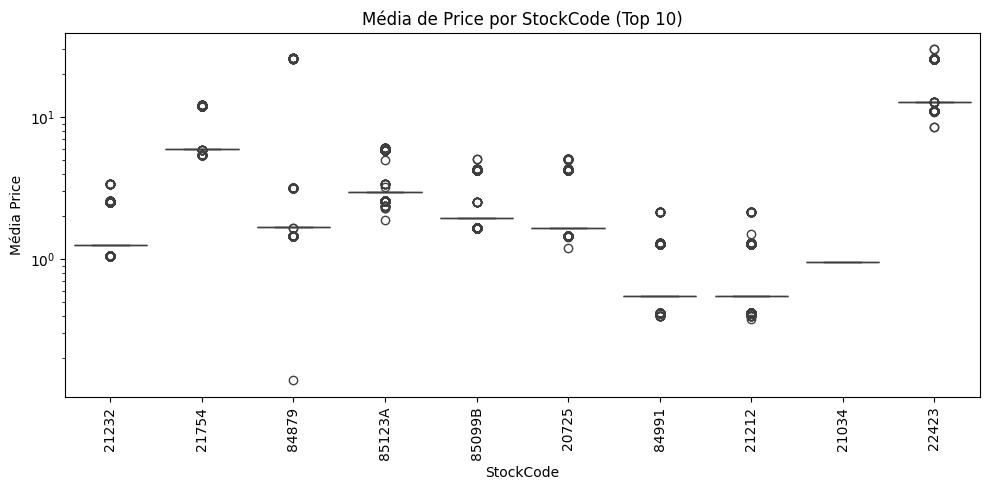

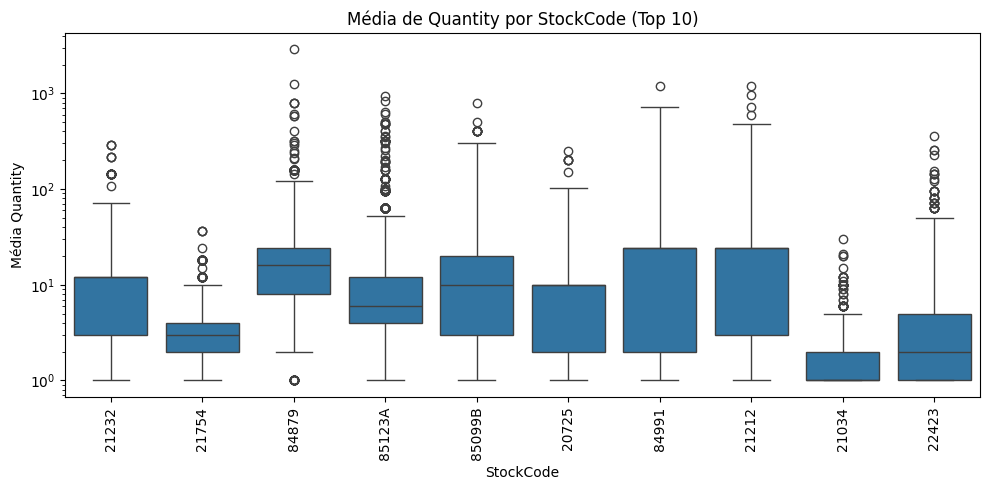

In [161]:

def barplot(df, x, y, top=10):
    top_groups = df[x].value_counts().head(top).index
    df_top = df[df[x].isin(top_groups)]
    
    plt.figure(figsize=(10, 5))
    sns.boxplot(
        data=df_top,
        x=x,
        y=y,
        log_scale=True
    )
    plt.title(f'Média de {y} por {x} (Top {top})')
    plt.xticks(rotation=90)
    plt.xlabel(x)
    plt.ylabel(f'Média {y}')
    plt.tight_layout()
    plt.show()
boxplot(specified_countries_df, 'Country', 'Price')
boxplot(specified_countries_df, 'Country', 'Quantity')
boxplot(specified_countries_df, 'StockCode', 'Price')
boxplot(specified_countries_df, 'StockCode', 'Quantity')

Preços com cauda longa para valores mais altos tanto para país quanto para produtos (faz sentido, há limite para quão baixo o preço é, mas não para quão alto).  Preços por produtos bem dispersos.

### Conclusão

Antes da aplicação da ANOVA, realizou-se uma análise descritiva para compreender o comportamento das variáveis de interesse (Quantity e Price) e identificar possíveis padrões entre os países. Também foram removidos registros contendo valores negativos, que correspondem a devoluções, cancelamentos ou ajustes no sistema, de modo a manter apenas vendas efetivas na análise

In [163]:
actual_df = specified_countries_df

## Comparação entre Paı́ses (ANOVA)

Rodemos ANOVA sobre países:

In [212]:
import scipy.stats as stats

from scipy import stats

def anova(df, factor, value):
    # Clean up off missing values
    data = df[[factor, value]].dropna()
    groups = [group[value].values for _, group in data.groupby(factor)]
    f_stat, p_val = stats.f_oneway(*groups)

    # Degrees of freedom
    k = len(groups)           # number of categories
    N = sum(len(g) for g in groups)  # total samples
    df_between = k - 1
    df_within = N - k
    return (
        factor,
        df_between,
        df_within,
        f_stat, 
        p_val
    )

(
    factor,
    df_between,
    df_within,
    f_stat,
    p_value
) = anova(actual_df, 'Country', 'Price')

print(
    f"{factor}:\tF({df_between}, {df_within}) = "
    f"{f_stat:.3f}, p = {p_value:.3e}")


Country:	F(38, 511221) = 5.225, p = 1.294e-23


Temos um _p-value_ muito pequeno, bem menor que e.g. 0,05. Podemos facilmente _rejeitar a hipótese de que não há diferença significativa entre preços._ Em outras palavras, **há diferença estatisticamente significativa entre os preços médios dos países.**

Não só isso, $F = 5,225$ indica variância entre países cinco vezes maior que variância dentro de países. Não só há differença estatisticamente significativa, **a variabilidade entre dos paísees é considerável, na ordem de 5 vezes a variação interna dos páises**.

## Validação de pressupostos

### Normalidade de resídulos

Vejamos o QQ-plot:

<Figure size 600x600 with 0 Axes>

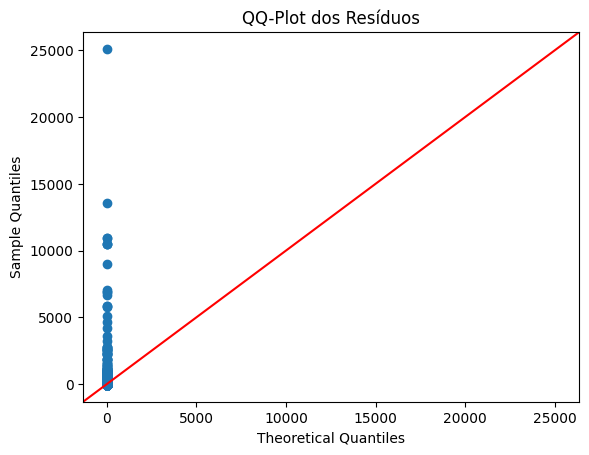

In [213]:
from statsmodels.formula.api import ols

model = ols("Price ~ C(Country)", data=actual_df).fit()

residuals = model.resid


plt.figure(figsize=(6, 6))
sm.qqplot(residuals, line='45')
plt.title("QQ-Plot dos Resíduos")
plt.show()

Claramente os resíduos não seguem distribuição normal! Vejamos um histograma:

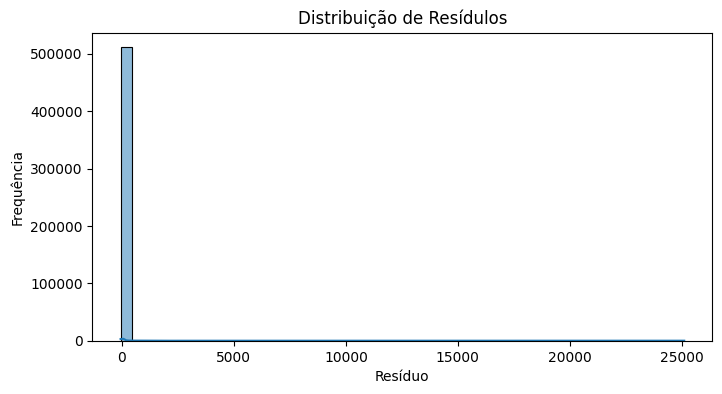

In [218]:
plt.figure(figsize=(8, 4))
sns.histplot(residuals, bins=50, kde=True)
plt.title('Distribuição de Resídulos')
plt.xlabel('Resíduo')
plt.ylabel('Frequência')
plt.show()

Muitos valores perto de zero! Vejamos em escala logaritmica:

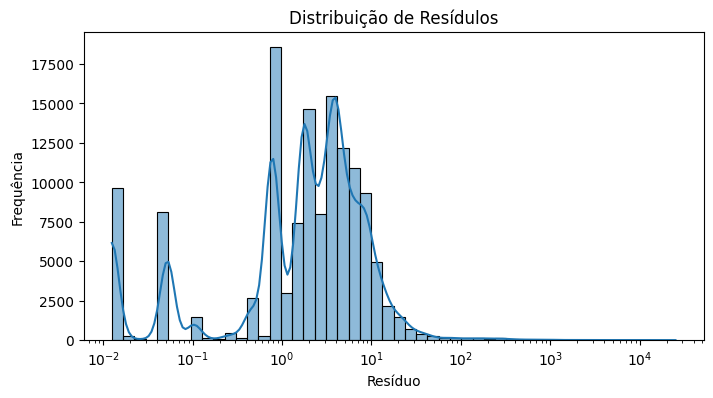

In [226]:
plt.figure(figsize=(8, 4))
sns.histplot(residuals, bins=50, kde=True, log_scale=(True, False))
plt.title('Distribuição de Resídulos')
plt.xlabel('Resíduo')
plt.ylabel('Frequência')
plt.show()

Ainda desbalanceado, mas mais próximo de resíduos normais. Vamos calcular ANOVA com o logaritmo dos preços:

In [230]:
actual_df['Price:log'] = np.log1p(actual_df['Price'])
(
    factor,
    df_between,
    df_within,
    f_stat,
    p_value
) = anova(actual_df, 'Country', 'Price:log')

print(
    f"{factor}:\tF({df_between}, {df_within}) = "
    f"{f_stat:.3f}, p = {p_value:.3e}")

Country:	F(38, 511221) = 31.139, p = 2.730e-223


In [ ]:
Vejamos os resídulos:

<Figure size 600x600 with 0 Axes>

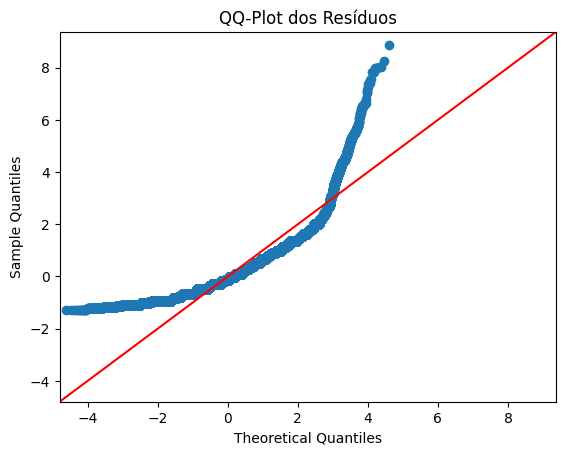

In [256]:
log_model = ols('Q("Price:log") ~ C(Country)', data=actual_df).fit()

residuals = log_model.resid

plt.figure(figsize=(6, 6))
sm.qqplot(residuals, line='45')
plt.title("QQ-Plot dos Resíduos")
plt.show()

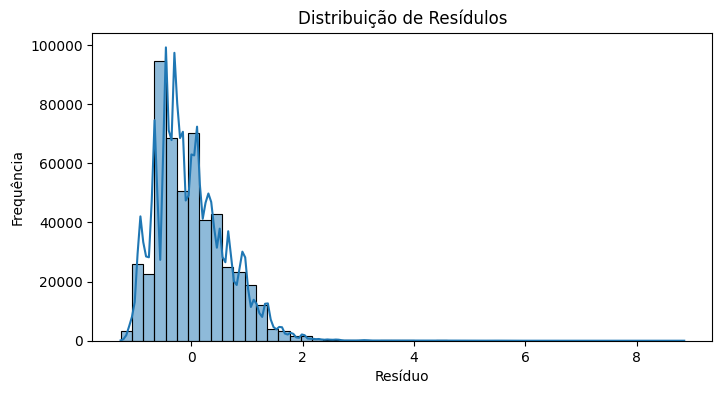

In [257]:
plt.figure(figsize=(8, 4))
sns.histplot(residuals, bins=50, kde=True)
plt.title('Distribuição de Resídulos')
plt.xlabel('Resíduo')
plt.ylabel('Frequência')
plt.show()

Bem melhor, mas ainda não totalmente normal. ANOVA é resiliente para amostras grandes como a nossa, porém. Esse efeito, talvez causado pelos outliers (temos produtos com valores bem altos!) não necessariamente invalida o modelo.

### Homocedasticidade

Verificemos a homocedasticidade dos resídulos, podemos usar o [teste de Breusch-Pagan](https://statorials.org/pt/teste-de-breusch-pagao/).

In [253]:
from scipy.stats import levene
actual_df['residuals'] = residuals
def print_levene(df, factor, output):
    groups = [group[output].values for name, group in df.groupby(factor)]
    
    stat, p_value = levene(*groups, center='median')  # ou center='mean'
    print(f"Levene stat={stat:.3f}, p={p_value:.3e}")

print_levene(actual_df, "Country", "Price:log")
print_levene(actual_df, "Country", "residuals")


Levene stat=15.318, p=1.725e-98
Levene stat=15.318, p=1.725e-98


Tanto o preço (log) quanto os resídulos são heterocedásticos. Vamos usar então OLS robusta:

In [267]:
robust_model = log_model.get_robustcov_results(cov_type="HC3")
robust_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Q("Price:log")   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     33.61
Date:                Wed, 26 Nov 2025   Prob (F-statistic):          5.31e-243
Time:                        11:09:27   Log-Likelihood:            -4.9947e+05
No. Observations:              511260   AIC:                         9.990e+05
Df Residuals:                  511221   BIC:                         9.995e+05
Df Model:                          38                                         
Covariance Type:                  HC3                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                              1.1766      0.027     43.761      0.000       1.124       1.229
C(Country)[T.Austria]                  0.0213      0.042      0.501      0.616      -0.062       0.105
C(Country)[T.Bahrain]                  0.1229      0.060      2.051      0.040       0.005       0.240
C(Country)[T.Belgium]                  0.0933      0.035      2.676      0.007       0.025       0.162
C(Country)[T.Bermuda]                 -0.1024      0.102     -1.003      0.316      -0.303       0.098
C(Country)[T.Brazil]                  -0.2217      0.059     -3.785      0.000      -0.337      -0.107
C(Country)[T.Canada]                  -0.1999      0.056     -3.555      0.000      -0.310      -0.090
C(Country)[T.Channel Islands]          0.2116      0.038      5.584      0.000       0.137       0.286
C(Country)[T.Cyprus]                   0.2582      0.038      6.714      0.000       0.183       0.334
C(Country)[T.Denmark]                 -0.1531      0.042     -3.637      0.000      -0.236      -0.071
C(Country)[T.EIRE]                     0.1492      0.028      5.339      0.000       0.094       0.204
C(Country)[T.Finland]                  0.0346      0.046      0.753      0.452      -0.056       0.125
C(Country)[T.France]                  -0.0301      0.028     -1.065      0.287      -0.086       0.025
C(Country)[T.Germany]                  0.0248      0.028      0.890      0.373      -0.030       0.079
C(Country)[T.Greece]                   0.1215      0.040      3.071      0.002       0.044       0.199
C(Country)[T.Hong Kong]                0.0717      0.136      0.528      0.598      -0.195       0.338
C(Country)[T.Iceland]                 -0.1039      0.063     -1.650      0.099      -0.227       0.020
C(Country)[T.Israel]                   0.0883      0.073      1.202      0.229      -0.056       0.232
C(Country)[T.Italy]                    0.1605      0.038      4.226      0.000       0.086       0.235
C(Country)[T.Japan]                   -0.2105      0.043     -4.864      0.000      -0.295      -0.126
C(Country)[T.Korea]                   -0.0839      0.066     -1.273      0.203      -0.213       0.045
C(Country)[T.Lebanon]                  0.3892      0.241      1.613      0.107      -0.084       0.862
C(Country)[T.Lithuania]               -0.0098      0.046     -0.215      0.830      -0.099       0.080
C(Country)[T.Malta]                    0.1183      0.075      1.585      0.113      -0.028       0.265
C(Country)[T.Netherlands]             -0.1268      0.029     -4.367      0.000      -0.184      -0.070
C(Country)[T.Nigeria]                 -0.0029      0.132     -0.022      0.982      -0.262       0.256
C(Country)[T.Norway]                  -0.1701      0.051     -3.333      0.001      -0.270      

O p-valor segue muito baixo, $5,31 \times 10^{-243}$ logo há de fato diferença entre as médias dos países.

## Interpretação e Tomada de Decisão

Temos variação estatisticamente significativa (p-valor baixo) mas o tamanho da variância dos preços não é necessariamente grande ($R^2$ baixo). 

In [274]:
coef_df = pd.DataFrame({
    "country": model.params.index,
    "coefficient": np.exp(model.params.values)
}).sort_values(by='coefficient')
coef_df

,country,coefficient
5,C(Country)[T.Brazil],0.801129
19,C(Country)[T.Japan],0.810172
6,C(Country)[T.Canada],0.818779
38,C(Country)[T.West Indies],0.834363
26,C(Country)[T.Norway],0.843605
9,C(Country)[T.Denmark],0.858080
24,C(Country)[T.Netherlands],0.880920
36,C(Country)[T.United Arab Emirates],0.897658
16,C(Country)[T.Iceland],0.901294
4,C(Country)[T.Bermuda],0.902639


Brasil tem o menor coeficiente, enquanto Líbano tem o maior. Isso pode ajudar a definir preços.

Dito isto, esta análise **não** oferece muito além de uma visão por alto dos níveis de preço. Decisões estratégicas reais dependeriam também do produto em questão. Essa análise pode ajudar, talvez, a decidir-se sobre entrar, ou aumentar presença, em um país, dependendo do interesse de atacar níveis de preços mais altos ou mais baixos.